# Обнаружение и локализация отказов инерциальной навигационной системы ODIN UAV
Имеется 4 папки с данными при разлиичных продольных скоростях движения объекта. В каждой папке по 280 измерений показаний ИНС (каждая серия длится 50 секунд с интервалом 0.1).

In [3]:
import pandas as pd
import glob
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(0)

In [93]:
file = 'dataset/velocity2/experiment121.csv'
df = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
df.head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_u2,fault_y1,fault_y2,comp_fault
0,-0.240246,-0.228259,-0.087066,-0.321061,-0.009765,-0.344491,0.0,0.0,0.0,0.0,0.0
1,-0.240246,-0.228259,0.015985,-0.164281,-0.009262,-0.161122,0.0,0.0,0.0,0.0,0.0
2,-0.240246,-0.228259,-0.036406,-0.143049,-0.004363,-0.070550,0.0,0.0,0.0,0.0,0.0
3,-0.240246,-0.228259,0.024768,-0.064049,-0.001919,-0.030836,0.0,0.0,0.0,0.0,0.0
4,-0.240246,-0.228259,-0.082591,-0.065805,-0.000846,-0.013743,0.0,0.0,0.0,0.0,0.0


Данные представляют собой временные ряды:

- u1, u2 - сигналы управления аппаратом
- y1, y2 - измерения гироскопа и акселерометра
- y_nominal1,	y_nominal2 - ожидаемые показания гироскопа и акселерометра
- fault_u1, fault_u2 - отказы систем управления (не присутствуют в датасете и не рассматриваются)
- fault_y1, fault_y2 - отказы гироскопа и акселерометра (0 - отсутствие отказаб другие значения - различные формы отказов)
- comp_fault - отказ компонента UAV (не присутствуют в датасете и не рассматриваются)

Требуется определить наличие отказа инерциальной навигационной системы (гироскопа или акселерометра). **Target**: fault_y1, fault_y2

Требуется решить задачу классификации временных рядов 

Будем рассматривать окно длиной 10 измерений (1 секунда). Будем считать, что отказ произошел, если целевая переменная имеет ненулевое значение на всем окне. 

In [121]:
files = glob.glob('dataset/*/*.csv')

measurement_step = 10

data = []
for file in files:
  if(file != 'data_model.csv'):
      temp = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
      indexes = range(0, temp.shape[0], measurement_step)
      temp = temp.iloc[indexes][:]
      temp.reset_index(inplace=True)
      data.append(temp)      
len(data)

1120

Уберем строки, не относящиеся к отказу ИНС и заменим ненулевые значения отказов на 1.

In [122]:
drop_cols = ['fault_u1', 'fault_u2', 'comp_fault', 'index']

for experiment in data:
    experiment.drop(drop_cols, inplace=True, axis=1)
    experiment['fault_y1'].replace([1., 2., 3,], 1, inplace=True)
    experiment['fault_y2'].replace([1., 2., 3,], 1, inplace=True)
data[23].head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2
0,0.295509,-0.106547,0.011852,-0.003908,0.006568,-0.066288,0.0,0.0
1,0.295509,-0.106547,-0.018340,0.025243,0.000022,-0.000476,0.0,0.0
2,0.295509,-0.106547,0.012469,0.055155,0.000021,-0.000435,0.0,0.0
3,0.295509,-0.106547,-0.039980,-0.003755,0.000021,-0.000435,0.0,0.0
4,0.295509,-0.106547,-0.049325,-0.037429,0.000021,-0.000435,0.0,0.0


In [123]:
data[133].shape

(50, 8)

Сформируем датасет следующим образом: 
- скользящее окно длиной 10 по каждому из экспериментов
- отказ датчика произошел, если на протяжении окна сигнал отказа имеет значение 1

In [124]:
new_cols = []
for col in data[0].drop(['fault_y1', 'fault_y2'], axis=1).columns:
    new_cols += [col + '_' + str(i) for i in range(10)]
new_cols += ['fault_y1', 'fault_y2']

In [127]:
df = pd.DataFrame(data=None, columns=new_cols)
df

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,y_nominal2_2,y_nominal2_3,y_nominal2_4,y_nominal2_5,y_nominal2_6,y_nominal2_7,y_nominal2_8,y_nominal2_9,fault_y1,fault_y2


In [130]:
lag = 9
for k, experiment in enumerate(data):
    for i in range(lag, experiment.shape[0]):
        sample = []
        u1_data = list(experiment.loc[(i-lag):i]['u1'])
        u2_data = list(experiment.loc[(i-lag):i]['u2'])
        y1_data = list(experiment.loc[(i-lag):i]['y1'])
        y2_data = list(experiment.loc[(i-lag):i]['y1'])
        y_nominal1_data = list(experiment.loc[(i-lag):i]['y_nominal1'])
        y_nominal2_data = list(experiment.loc[(i-lag):i]['y_nominal2'])
        
        sample_fault_y1 = list(experiment.loc[(i-lag):i]['fault_y1'])
        if sum(sample_fault_y1) == 10:
            fault_y1_data = [1]
        else:
            fault_y1_data = [0]
            
        sample_fault_y2 = list(experiment.loc[(i-lag):i]['fault_y2'])
        if sum(sample_fault_y2) == 10:
            fault_y2_data = [1]
        else:
            fault_y2_data = [0]
        sample = u1_data + u2_data + y1_data + y2_data + y_nominal1_data + y_nominal2_data + fault_y1_data + fault_y2_data
        df.loc[len(df)] = sample
    if k % 20 == 0:
        print(k, ' of ', len(data))

0  of  1120
20  of  1120
40  of  1120
60  of  1120
80  of  1120
100  of  1120
120  of  1120
140  of  1120
160  of  1120
180  of  1120
200  of  1120
220  of  1120
240  of  1120
260  of  1120
280  of  1120
300  of  1120
320  of  1120
340  of  1120
360  of  1120
380  of  1120
400  of  1120
420  of  1120
440  of  1120
460  of  1120
480  of  1120
500  of  1120
520  of  1120
540  of  1120
560  of  1120
580  of  1120
600  of  1120
620  of  1120
640  of  1120
660  of  1120
680  of  1120
700  of  1120
720  of  1120
740  of  1120
760  of  1120
780  of  1120
800  of  1120
820  of  1120
840  of  1120
860  of  1120
880  of  1120
900  of  1120
920  of  1120
940  of  1120
960  of  1120
980  of  1120
1000  of  1120
1020  of  1120
1040  of  1120
1060  of  1120
1080  of  1120
1100  of  1120


In [133]:
df.shape

(85990, 62)

In [135]:
df.to_csv('dataset_preprocessed.csv')

## EDA

Рассмотрим сбалансированность датасета

In [30]:
df = pd.read_csv('dataset_preprocessed.csv', index_col=0)
df.head()

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,y_nominal2_2,y_nominal2_3,y_nominal2_4,y_nominal2_5,y_nominal2_6,y_nominal2_7,y_nominal2_8,y_nominal2_9,fault_y1,fault_y2
0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.000179,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.000180,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.000180,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.000180,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.000180,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0


In [26]:
n_faults_y1 = df['fault_y1'].value_counts()[1]
n_faults_y2 = df['fault_y2'].value_counts()[1]
n_no_faults = df.shape[0] - n_faults_y1 - n_faults_y2

In [4]:
data = dict(
    categories = ['Total', 'No fault', 'Fault','Fault y1', 'Fault y2'],
    parent = ['', 'Total', 'Total', 'Fault', 'Fault'],
    value = [df.shape[0], n_no_faults, n_faults_y1+n_faults_y2, n_faults_y1, n_faults_y2]
)

fig = px.sunburst(data, names='categories', parents='parent', values='value', branchvalues='total')
fig.show()

Датасет несбалансирован по классу отсутсвия отказов. Потребуется стратифицированная выборка

Рассмотрим влияние разных сигналов на наличие отказа. Для удобства создадим столбец с кодированием LE 

In [31]:
df['fault_LE'] = 0
df['fault_LE'].loc[ (df['fault_y1'] == 0) & (df['fault_y1'] == 0)] = 0
df['fault_LE'].loc[df['fault_y1'] == 1] = 1
df['fault_LE'].loc[df['fault_y2'] == 1] = 2
df['fault_LE'].value_counts()

c:\python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0    63704
2    11227
1    11059
Name: fault_LE, dtype: int64

In [28]:
df.head()

,Unnamed: 0,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,...,y_nominal2_3,y_nominal2_4,y_nominal2_5,y_nominal2_6,y_nominal2_7,y_nominal2_8,y_nominal2_9,fault_y1,fault_y2,fault_LE
0,0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
1,1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
2,2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
3,3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
4,4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0


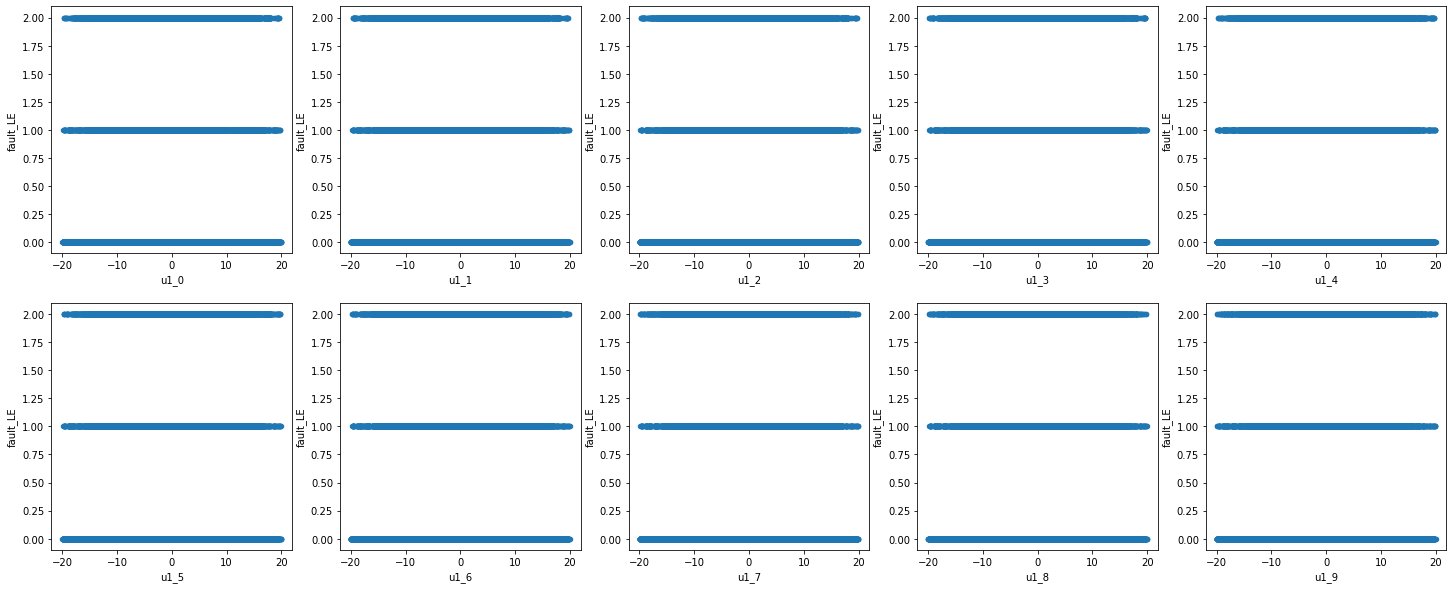

In [30]:
def plot_on_key(df, key):
    cols = [col for col in df.columns if key in col and 'fault' not in col]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    for idx, feature in enumerate(cols):
        df.plot(feature, "fault_LE", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])
    plt.show()
plot_on_key(df, 'u1')

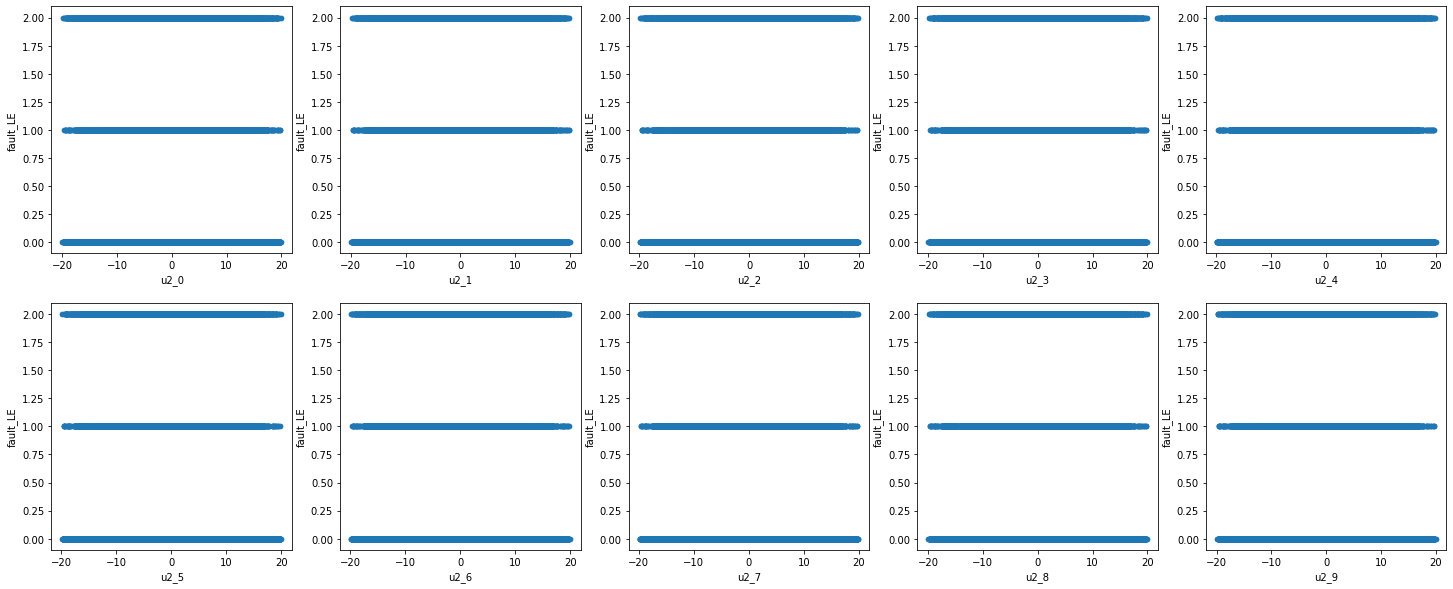

In [31]:
plot_on_key(df, 'u2')

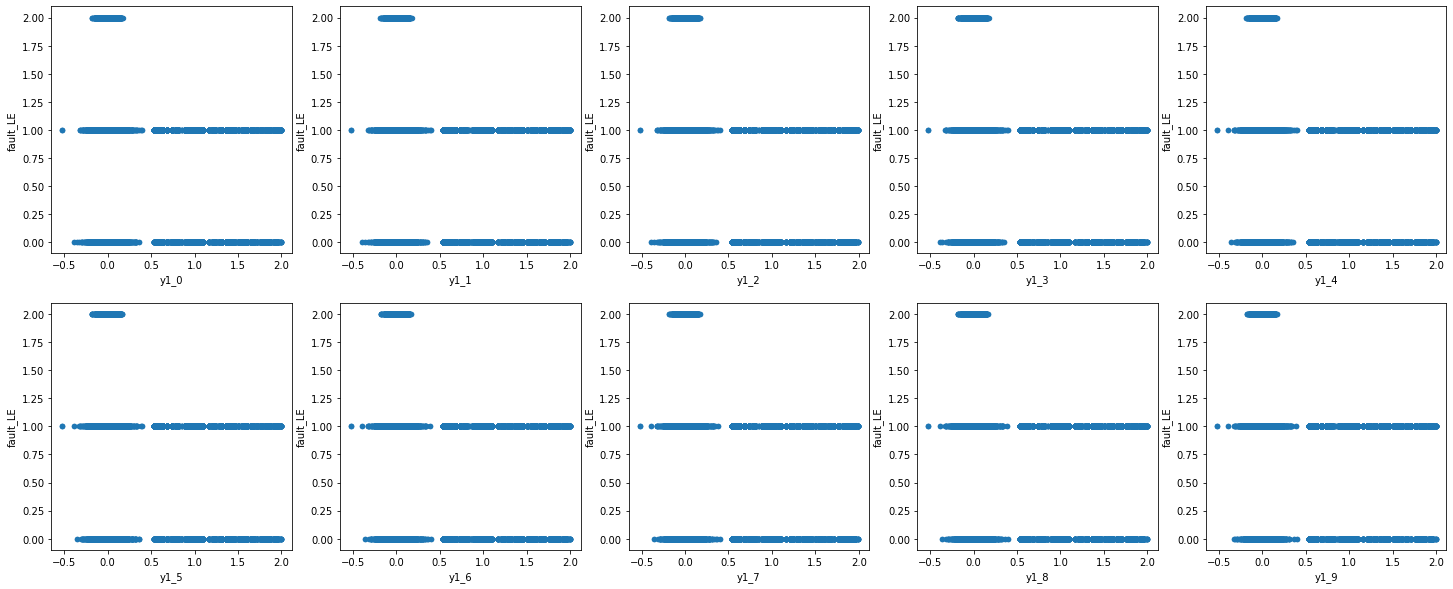

In [32]:
plot_on_key(df, 'y1')

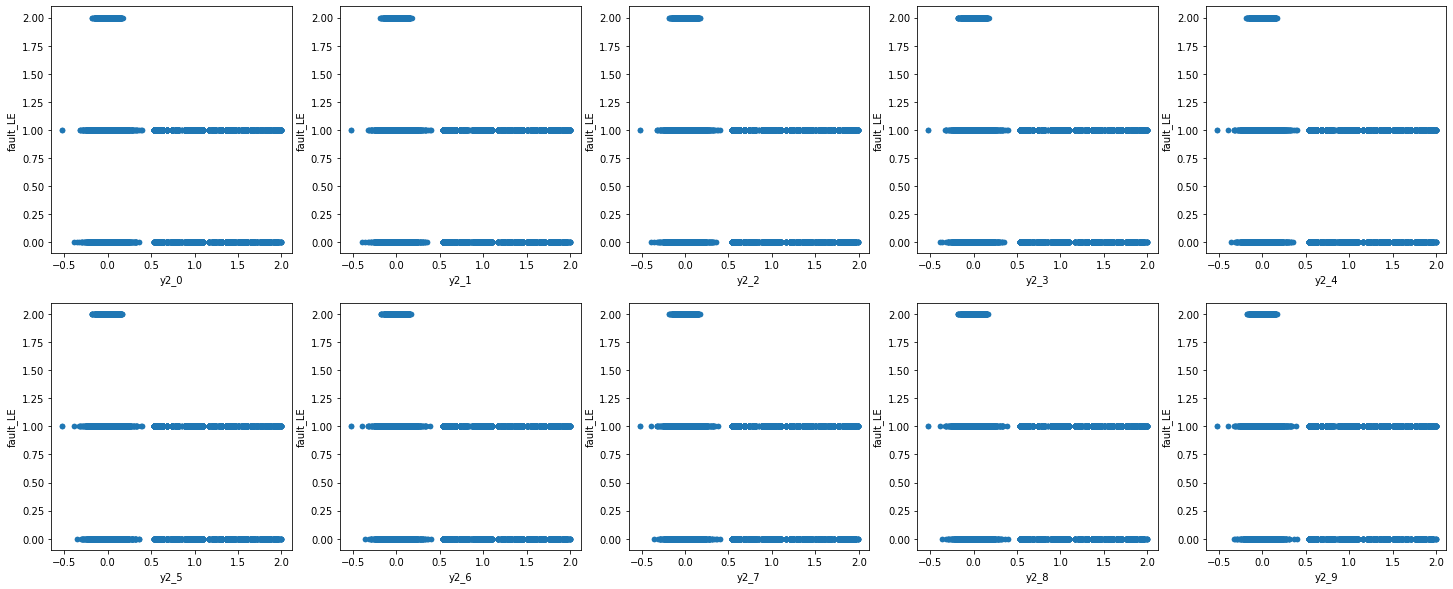

In [33]:
plot_on_key(df, 'y2')

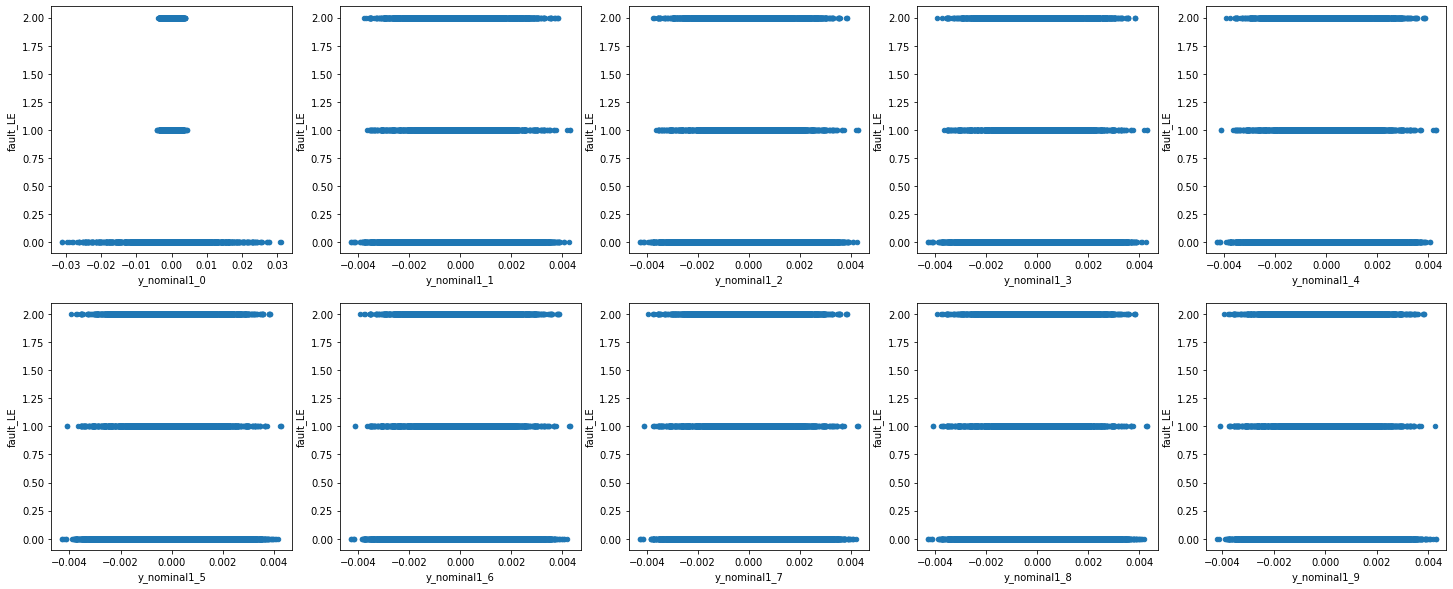

In [34]:
plot_on_key(df, 'y_nominal1')

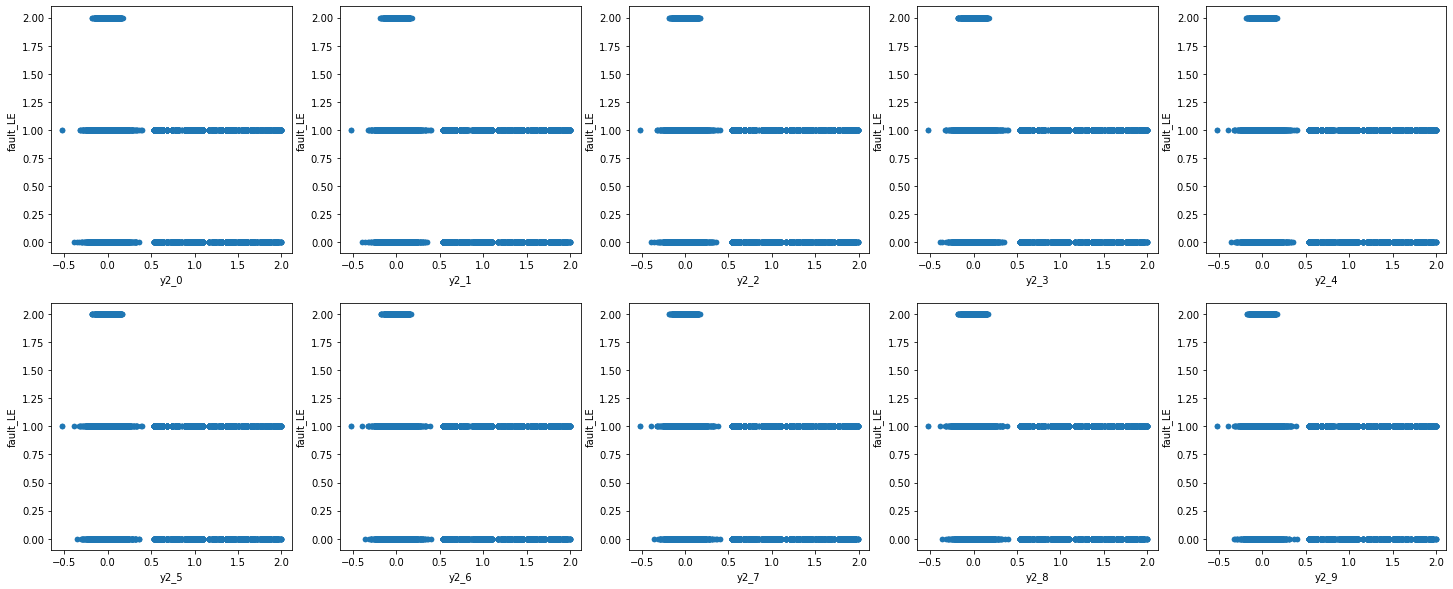

In [35]:
plot_on_key(df, 'y2')

Явных зависимостей не обнаружено

Просмотрим распределение признаков

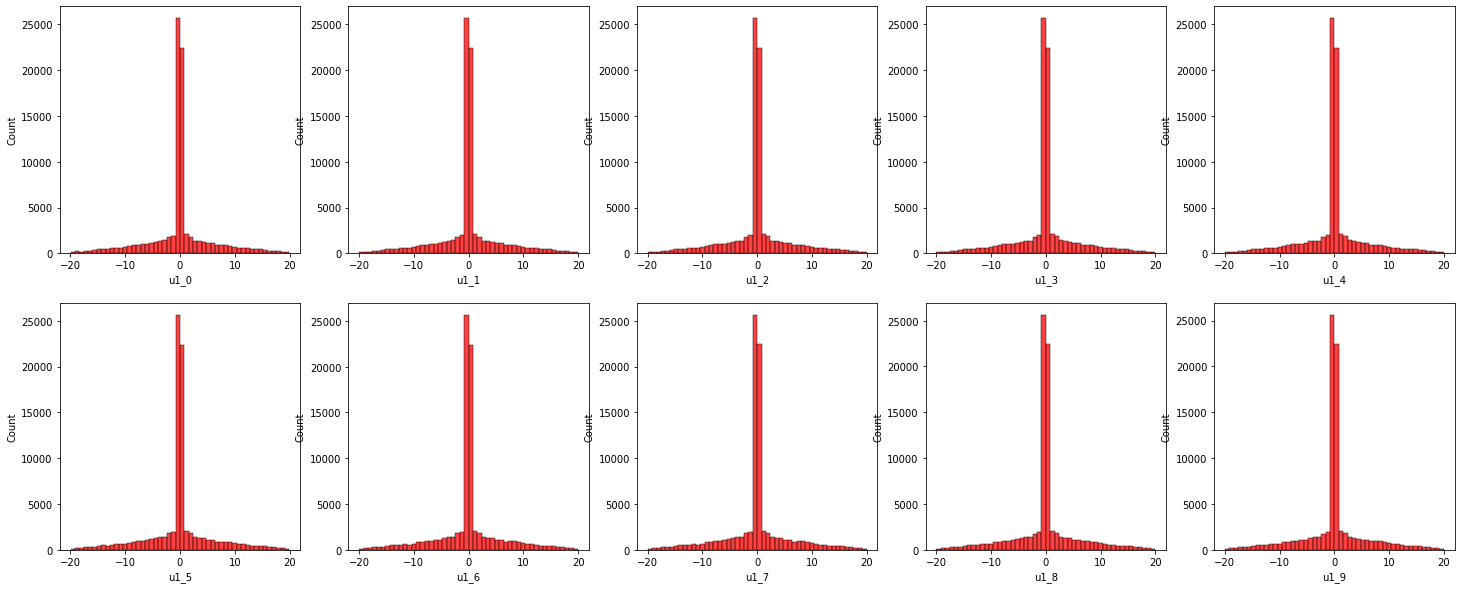

In [11]:
def distplot_on_key(df, key):
    cols = [col for col in df.columns if key in col and 'fault' not in col]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    for idx, feature in enumerate(cols):
        sns.histplot(df[feature], bins=50, color='r', ax=axes[idx // 5, idx % 5])
    plt.show()
distplot_on_key(df, 'u1')

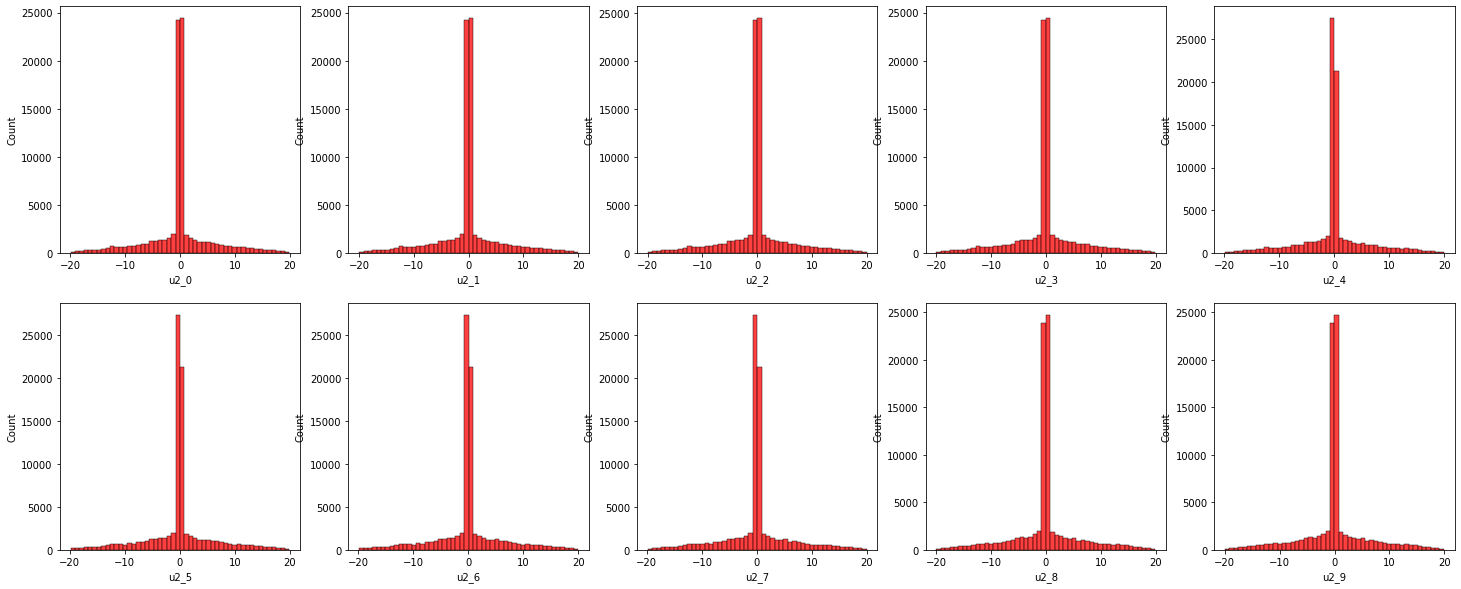

In [12]:
distplot_on_key(df, 'u2')

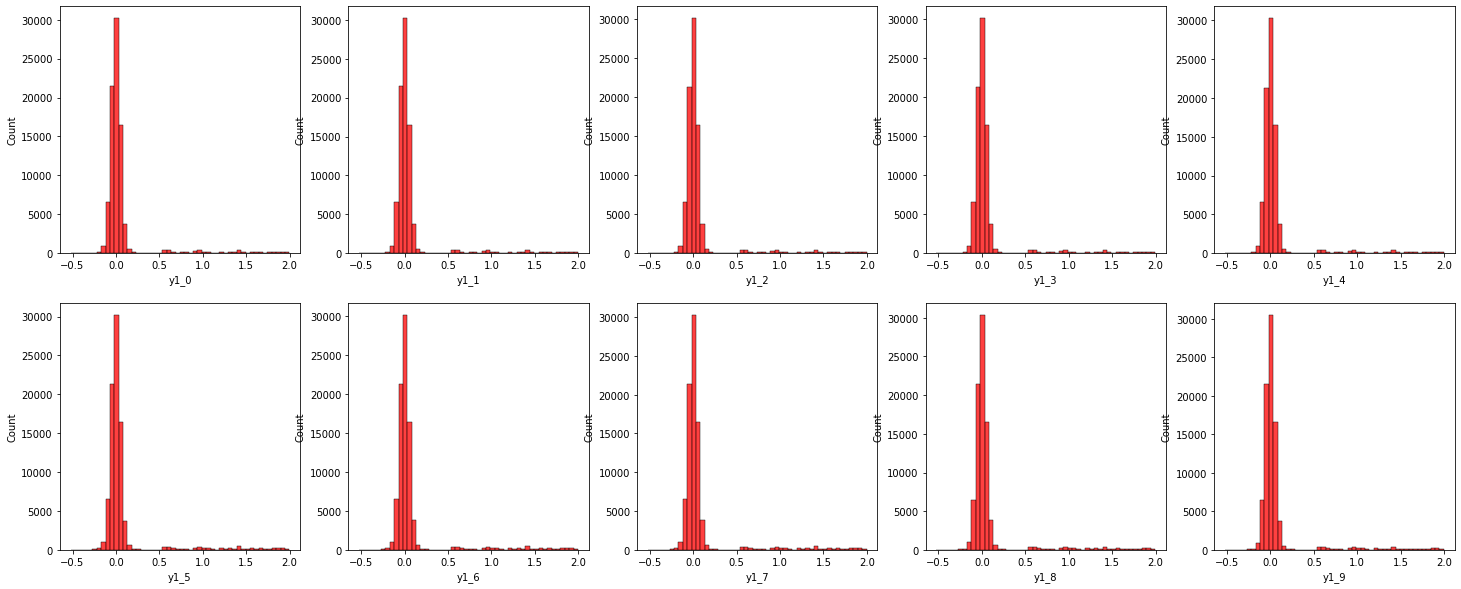

In [13]:
distplot_on_key(df, 'y1')

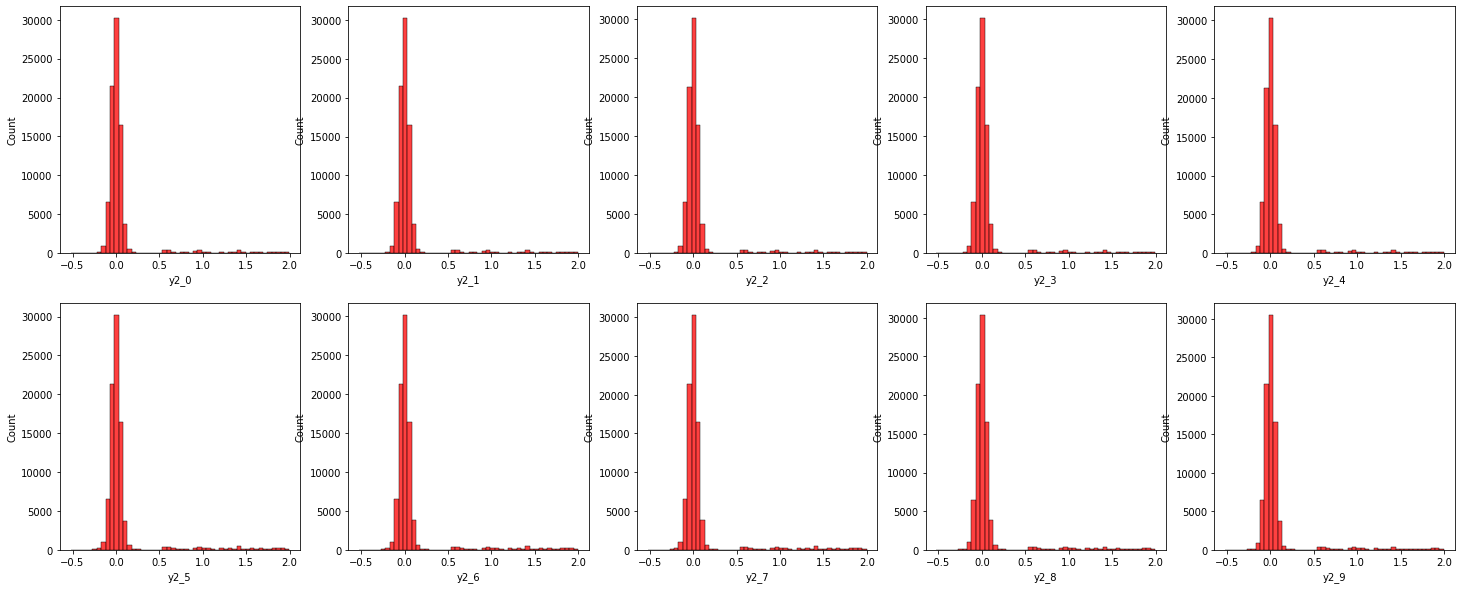

In [14]:
distplot_on_key(df, 'y2')

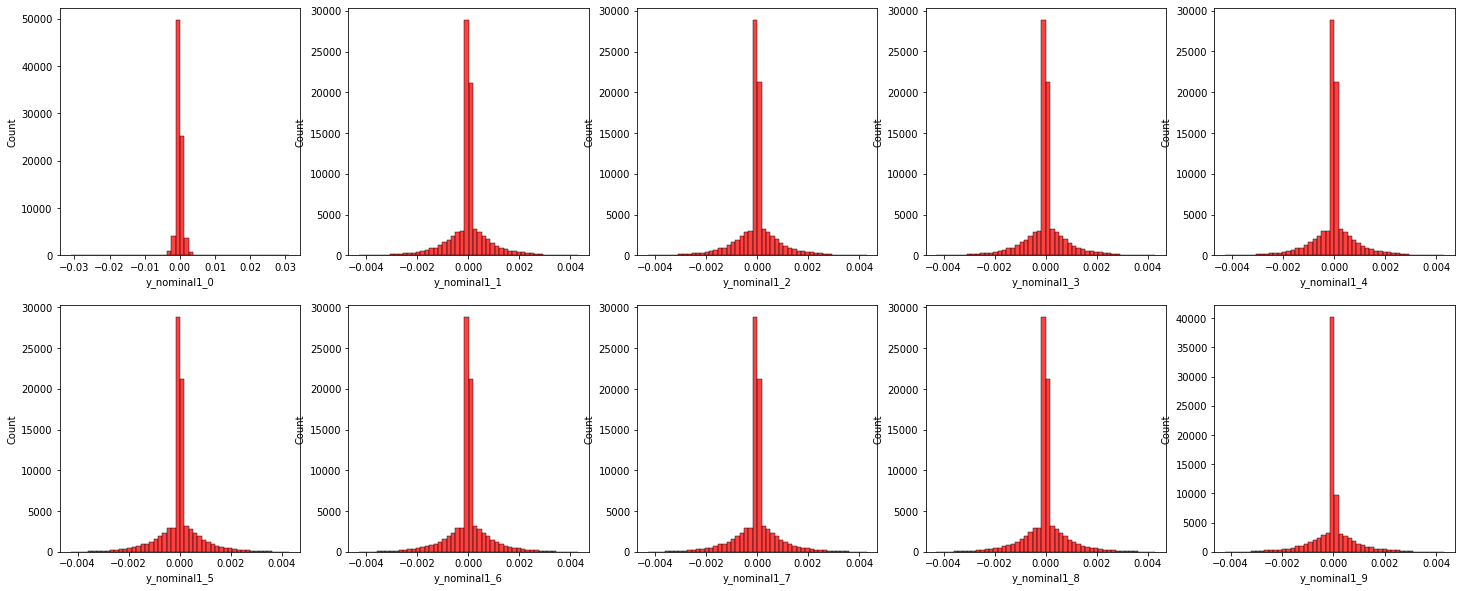

In [15]:
distplot_on_key(df, 'y_nominal1')

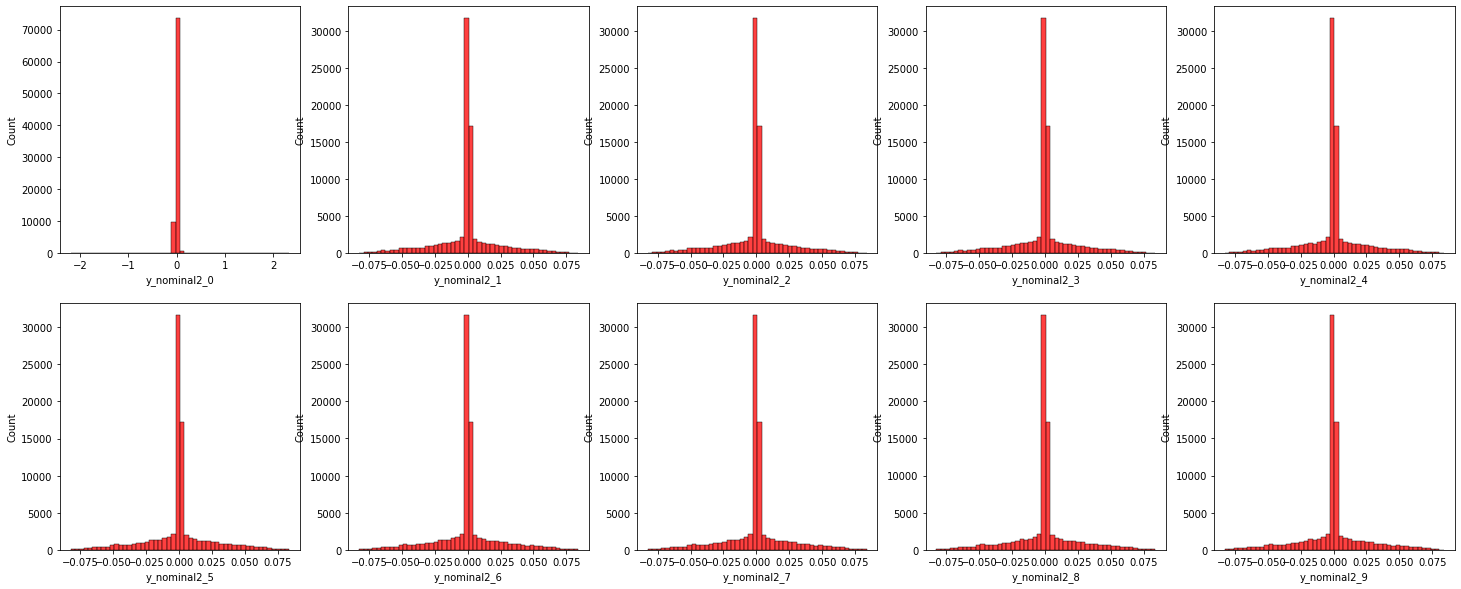

In [16]:
distplot_on_key(df, 'y_nominal2')

Распределение всех признаков близко к нормальному

Проверим корреляцию признаков

<AxesSubplot:>

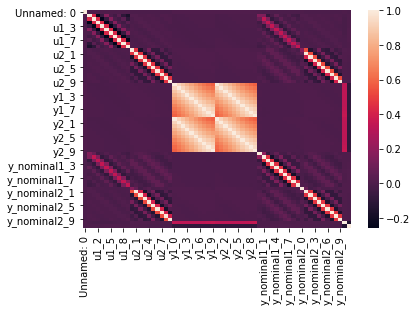

In [17]:
sns.heatmap(df.corr())

Есть существенно скоррелированые признаки, что объясняется невысокой динамикой объекта

Попробуем понизить размерность

In [8]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))

In [9]:
model = PCA(n_components=3)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

In [10]:
df_to_draw = pd.DataFrame({
    'class': df['fault_LE'],
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
    'pca3': pca_coords[:, 2],
})
colors = ['r', 'g', 'b']

In [11]:
df_to_draw.shape

(85990, 4)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000


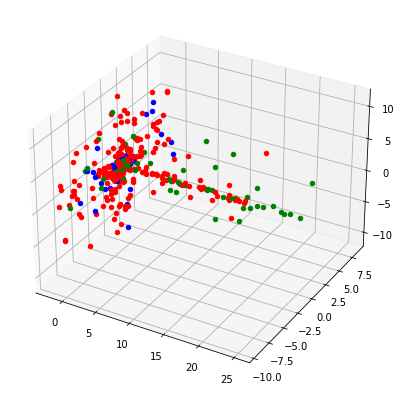

In [14]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

for k, f in enumerate(df_to_draw.iterrows()):
    if k % 100 == 0:
        ax.scatter(f[1]['pca1'], f[1]['pca2'], f[1]['pca3'], c=colors[int(f[1]['class'])])
    if k % 1000 == 0:
        print(k)
plt.show()

Разделимость плоскостью не наблюдается

## Feature engineering

Исходя из поставленной задачи, заменим измеренные и ожидаемые значения на их разницу

In [130]:
df_fe = df.copy()

In [131]:
y_cols = [col for col in df_fe.columns if 'y1' in col and 'fault' not in col]
y_nominal_cols = [col for col in df_fe.columns if 'y_nominal1' in col and 'fault' not in col]
for i in range(len(y_cols)):
    df_fe['dev_y1_'+ y_cols[i].split('_')[-1]] = df_fe[y_cols[i]] - df_fe[y_nominal_cols[i]]
    df_fe.drop([y_cols[i], y_nominal_cols[i]], axis=1, inplace=True)
    
y_cols = [col for col in df.columns if 'y2' in col and 'fault' not in col]
y_nominal_cols = [col for col in df.columns if 'y_nominal2' in col and 'fault' not in col]
for i in range(len(y_cols)):
    df_fe['dev_y2_'+ y_cols[i].split('_')[-1]] = df_fe[y_cols[i]] - df_fe[y_nominal_cols[i]]
    df_fe.drop([y_cols[i], y_nominal_cols[i]], axis=1, inplace=True)

In [132]:
df_fe.columns

Index(['u1_0', 'u1_1', 'u1_2', 'u1_3', 'u1_4', 'u1_5', 'u1_6', 'u1_7', 'u1_8',
       'u1_9', 'u2_0', 'u2_1', 'u2_2', 'u2_3', 'u2_4', 'u2_5', 'u2_6', 'u2_7',
       'u2_8', 'u2_9', 'fault_y1', 'fault_y2', 'fault_LE', 'dev_y1_0',
       'dev_y1_1', 'dev_y1_2', 'dev_y1_3', 'dev_y1_4', 'dev_y1_5', 'dev_y1_6',
       'dev_y1_7', 'dev_y1_8', 'dev_y1_9', 'dev_y2_0', 'dev_y2_1', 'dev_y2_2',
       'dev_y2_3', 'dev_y2_4', 'dev_y2_5', 'dev_y2_6', 'dev_y2_7', 'dev_y2_8',
       'dev_y2_9'],
      dtype='object')

Добавим скользящие средние c окном 5

In [133]:
cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col or
                                      'u1' in col or
                                      'u2' in col) and 'fault' not in col]
for col in cols:
    df_fe['roll_' + col] = df_fe[col].rolling(5).mean()

In [134]:
df_fe.shape

(85990, 83)

In [135]:
df_fe.head()

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,roll_dev_y2_0,roll_dev_y2_1,roll_dev_y2_2,roll_dev_y2_3,roll_dev_y2_4,roll_dev_y2_5,roll_dev_y2_6,roll_dev_y2_7,roll_dev_y2_8,roll_dev_y2_9
0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.081125,-0.024736,-0.019568,-0.021789,-0.013703,0.016857,0.018408,-0.005869,0.000323,0.005978


Добавим первые производные

In [136]:
cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col or
                                      'u1' in col or
                                      'u2' in col) and ('fault' not in col and 'roll' not in col)]
for col in cols:
    for i in range(1, 10):
        df_fe.loc[i, 'V_' + col] = df_fe.loc[i, col] - df_fe.loc[i-1, col]
df_fe.fillna(0, inplace=True)
df_fe.shape

(85990, 123)

In [137]:
df_fe.columns

Index(['u1_0', 'u1_1', 'u1_2', 'u1_3', 'u1_4', 'u1_5', 'u1_6', 'u1_7', 'u1_8',
       'u1_9',
       ...
       'V_dev_y2_0', 'V_dev_y2_1', 'V_dev_y2_2', 'V_dev_y2_3', 'V_dev_y2_4',
       'V_dev_y2_5', 'V_dev_y2_6', 'V_dev_y2_7', 'V_dev_y2_8', 'V_dev_y2_9'],
      dtype='object', length=123)

Добавим вторую производную

In [138]:
cols = [col for col in df_fe.columns if ('V_dev_y1' in col or
                                      'V_dev_y2' in col or
                                      'V_u1' in col or
                                      'V_u2' in col) and ('fault' not in col and 'roll' not in col)]
for col in cols:
    for i in range(1, 10):
        df_fe.loc[i, 'A' + col] = df_fe.loc[i, col] - df_fe.loc[i-1, col]
df_fe.fillna(0, inplace=True)
df_fe.shape


(85990, 163)

In [139]:
df_fe.to_csv('dataset_with_features.csv')

<AxesSubplot:>

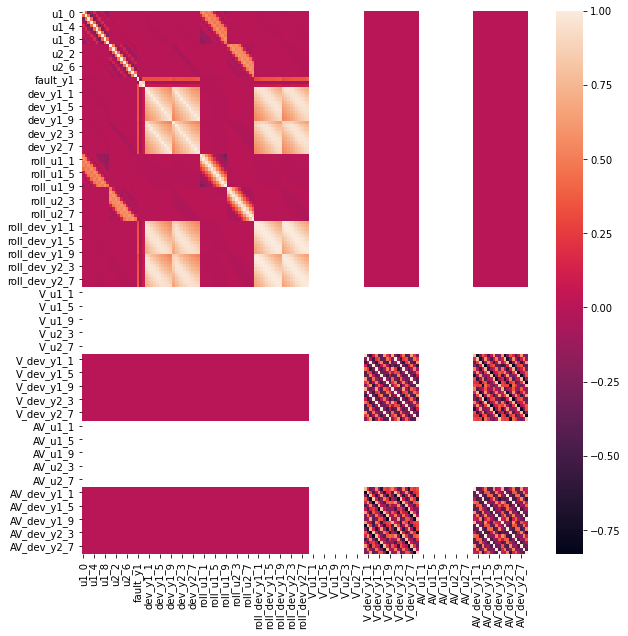

In [143]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_fe.corr())

Сгенерированные признаки имеют низкую корреляцию